# **Exploratory Data Analysis**

In [1]:
import pandas as pd
import numpy as np

# Load datasets
train_df = pd.read_csv('/kaggle/input/test-and-train-and-gender-submission-databases/train.csv')
test_df = pd.read_csv('/kaggle/input/test-and-train-and-gender-submission-databases/test.csv')

# Load the sample submission
gender_submission_df = pd.read_csv('/kaggle/input/test-and-train-and-gender-submission-databases/gender_submission.csv')

In [2]:
# Inspect the first few rows
print(train_df.head())

# Summary of train data
print(train_df.info())

# Summary statistics
print(train_df.describe())

# Check for missing values
print(train_df.isnull().sum())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

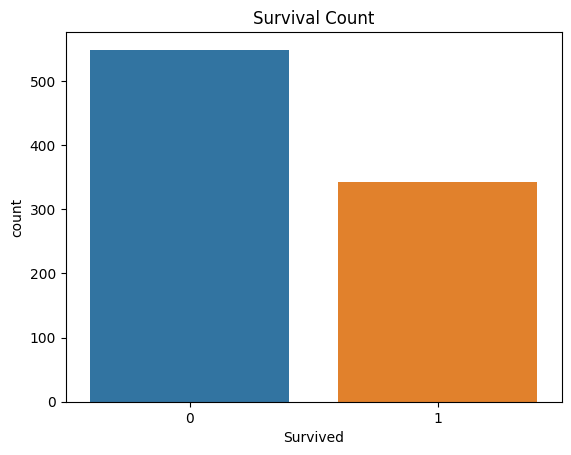

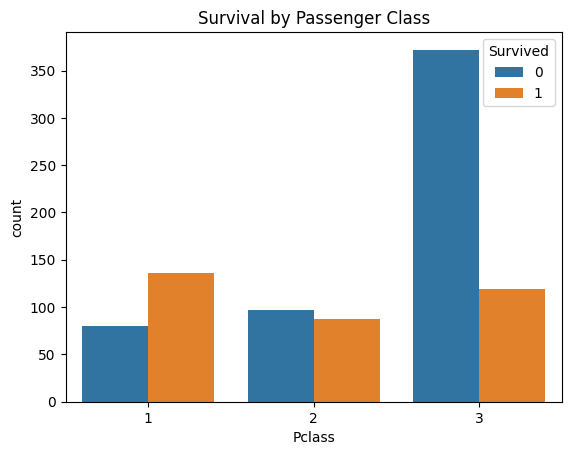

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


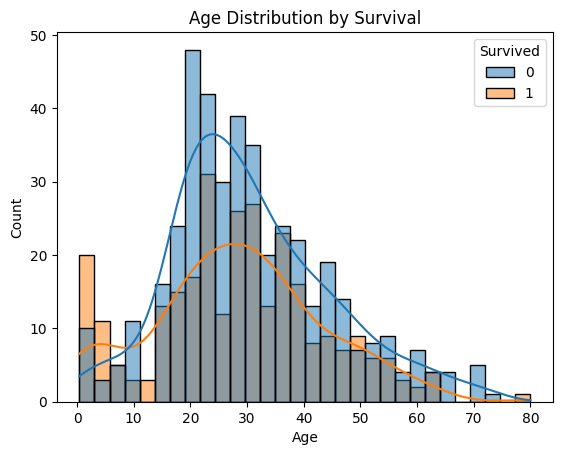

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Survival count
sns.countplot(x='Survived', data=train_df)
plt.title('Survival Count')
plt.show()

# Survival by Passenger Class
sns.countplot(x='Pclass', hue='Survived', data=train_df)
plt.title('Survival by Passenger Class')
plt.show()

# Age distribution for survivors vs. non-survivors
sns.histplot(data=train_df, x='Age', hue='Survived', kde=True, bins=30)
plt.title('Age Distribution by Survival')
plt.show()

# **Handling missing values**

In [4]:
# Fill missing 'Embarked' with the most common port
most_common_port = train_df['Embarked'].dropna().mode()[0]

# Instead of using inplace=True, do assignment
train_df['Embarked'] = train_df['Embarked'].fillna(most_common_port)
test_df['Embarked'] = test_df['Embarked'].fillna(most_common_port)

# Fill missing 'Age' with median
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].median())

# Handle missing 'Fare' in test set
# You have 1 missing Fare in test_df
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

# Create a new 'Deck' feature from 'Cabin', fill missing with 'U'
train_df['Deck'] = train_df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'U')
test_df['Deck'] = test_df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'U')

# Drop original 'Cabin' column
train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

print("Missing values in training set after cleaning:")
print(train_df.isnull().sum())
print("\nMissing values in test set after cleaning:")
print(test_df.isnull().sum())

# Convert Categorical Variables
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})

# One-Hot Encode 'Embarked' and 'Deck'
train_df = pd.get_dummies(train_df, columns=['Embarked', 'Deck'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Embarked', 'Deck'], drop_first=True)

# Align train_df and test_df so they have the same columns
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

Missing values in training set after cleaning:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Deck           0
dtype: int64

Missing values in test set after cleaning:
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Deck           0
dtype: int64


# **Feature engineering**

In [5]:
import re

# Create FamilySize feature
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

# Extract Title from Name
def extract_title(name):
    # Extract title using regex search
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

# Create a new column 'Title' for both train and test sets
train_df['Title'] = train_df['Name'].apply(extract_title)
test_df['Title'] = test_df['Name'].apply(extract_title)

# Standardize titles (grouping rare ones into a common 'Other' category)
def standardize_title(title):
    if title in ['Mr']:
        return 'Mr'
    elif title in ['Miss', 'Ms', 'Mlle']:
        return 'Miss'
    elif title in ['Mrs', 'Mme']:
        return 'Mrs'
    elif title in ['Master']:
        return 'Master'
    else:
        return 'Other'

train_df['Title'] = train_df['Title'].apply(standardize_title)
test_df['Title'] = test_df['Title'].apply(standardize_title)

# One-Hot Encode the 'Title' feature
train_df = pd.get_dummies(train_df, columns=['Title'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Title'], drop_first=True)

# align the datasets to ensure they have the same dummy columns
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

# Drop the original Name column if it's no longer needed
train_df.drop('Name', axis=1, inplace=True)
test_df.drop('Name', axis=1, inplace=True)

# Quick check of new features
print("Train dataset columns after feature engineering:")
print(train_df.columns)
print("\nTest dataset columns after feature engineering:")
print(test_df.columns)

Train dataset columns after feature engineering:
Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked_Q', 'Embarked_S', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U',
       'FamilySize', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other'],
      dtype='object')

Test dataset columns after feature engineering:
Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked_Q', 'Embarked_S', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U',
       'FamilySize', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other'],
      dtype='object')


# **Model Building & Evaluation**

## **Logistic Regression**

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Prepare features and target variable
X = train_df.drop(['PassengerId', 'Survived', 'Ticket'], axis=1)
y = train_df['Survived']

# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the validation set
y_pred = model.predict(X_val)

# Evaluate model performance
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.8044692737430168


## **Random Forest**

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

# Prepare features and target variable (drop 'PassengerId' and 'Ticket')
X = train_df.drop(['PassengerId', 'Survived', 'Ticket'], axis=1)
y = train_df['Survived']

# Initialize a RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Define a parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X, y)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Evaluate the best estimator on the validation set (if you have one separated)
# For example, using cross_val_score to estimate performance:
cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5)
print("Cross-validated accuracy:", cv_scores.mean())

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.8316301550436256
Cross-validated accuracy: 0.8316301550436256


In [8]:
X_test = test_df.drop(['PassengerId', 'Ticket', 'Survived'], axis=1, errors='ignore')

# Use the best estimator from GridSearchCV to predict survival on the test set
test_predictions = grid_search.best_estimator_.predict(X_test)

# Create the submission DataFrame. Make sure the submission includes only PassengerId and Survived.
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

# Save the submission file to CSV
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")

Submission file created successfully!
